# Imports

In [24]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
#from utils.custom_formatter import setup_logger
#logger = setup_logger(__name__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [25]:
# Import file
df = pd.read_parquet("../data/sp500_daily_data.parquet")

df

permno        date       ret    close         vol       open  \
0        10078  2000-01-03 -0.012107   76.500  15270527.0   79.25000   
1        10078  2000-01-04 -0.062092   71.750  21098710.0   73.43750   
2        10078  2000-01-05  0.001742   71.875  30073258.0   70.12500   
3        10078  2000-01-06 -0.053913   68.000  22741999.0   70.43750   
4        10078  2000-01-07  0.056985   71.875  20450260.0   67.18750   
...        ...         ...       ...      ...         ...        ...   
155298   93436  2024-12-24  0.073572  462.280  59351506.0  435.89999   
155299   93436  2024-12-26 -0.017630  454.130  76392273.0  465.16000   
155300   93436  2024-12-27 -0.049479  431.660  82370345.0  449.51999   
155301   93436  2024-12-30 -0.033012  417.410  64705452.0  419.39999   
155302   93436  2024-12-31 -0.032510  403.840  76455213.0  423.79001   

             high        low  cfacpr  
0        79.37500   74.50000     0.5  
1        75.25000   71.50000     0.5  
2        73.50000   66.62500     0.5  
3        71.87500   67.00000     0.5  
4        72.00000   66.75000     0.5  
...           ...        ...     ...  
155298  462.78000  435.14001     1.0  
155299  465.32990  451.01999     1.0  
155300  450.00000  426.50000     1.0  
155301  427.00000  415.75000     1.0  
155302  427.92999  402.54001     1.0  

[3155303 rows x 9 columns]

In [28]:


def adjust_for_splits(df:pd.DataFrame, base_cols=["close", "open", "high", "low"], factor_col="cfacpr"):
    """ 
    Refactor price for splits etc, keeping the first one as a base value    
    If the company has a 2:1 split and the price moves from 100 to 50
    Our timeseries will show t_0=50, t_1=50
    """
    # copy df
    df_out = df.copy()

    # filter
    df_out[base_cols] = df_out[base_cols].div(df_out[factor_col], axis=0) 

    return df_out[base_cols]



In [29]:
cols = ["close", "open", "high", "low"]
df[cols] = adjust_for_splits(df, cols)
df


permno        date       ret   close         vol       open  \
0        10078  2000-01-03 -0.012107  153.00  15270527.0  158.50000   
1        10078  2000-01-04 -0.062092  143.50  21098710.0  146.87500   
2        10078  2000-01-05  0.001742  143.75  30073258.0  140.25000   
3        10078  2000-01-06 -0.053913  136.00  22741999.0  140.87500   
4        10078  2000-01-07  0.056985  143.75  20450260.0  134.37500   
...        ...         ...       ...     ...         ...        ...   
155298   93436  2024-12-24  0.073572  462.28  59351506.0  435.89999   
155299   93436  2024-12-26 -0.017630  454.13  76392273.0  465.16000   
155300   93436  2024-12-27 -0.049479  431.66  82370345.0  449.51999   
155301   93436  2024-12-30 -0.033012  417.41  64705452.0  419.39999   
155302   93436  2024-12-31 -0.032510  403.84  76455213.0  423.79001   

             high        low  cfacpr  
0       158.75000  149.00000     0.5  
1       150.50000  143.00000     0.5  
2       147.00000  133.25000     0.5  
3       143.75000  134.00000     0.5  
4       144.00000  133.50000     0.5  
...           ...        ...     ...  
155298  462.78000  435.14001     1.0  
155299  465.32990  451.01999     1.0  
155300  450.00000  426.50000     1.0  
155301  427.00000  415.75000     1.0  
155302  427.92999  402.54001     1.0  

[3155303 rows x 9 columns]

In [30]:
# 0) Chronological order (always first)
df = df.sort_values(["permno", "date"]).copy()
g = df.groupby("permno", sort=False)

# 1) Robust basic fills by variable type
# Returns & volume: scalar fills are fine (no groupby needed)
if "ret" in df.columns:
    df["ret"] = df["ret"].fillna(0)
if "vol" in df.columns:
    df["vol"] = df["vol"].fillna(0)

# 2) Prices: use *forward-fill within each stock* (causal, no peeking)
for c in ["close", "low", "high"]:
    if c in df.columns:
        df[c] = g[c].ffill()

# 3) Open: first try yesterday's close, then carry forward within the stock
if {"open", "close"}.issubset(df.columns):
    prev_close = g["close"].shift(1)
    df["open"] = df["open"].fillna(prev_close)
    df["open"] = g["open"].ffill()

    # 3b) Fallback ONLY for rows where open is still NaN (typically first obs per permno)
    mask_open_na = df["open"].isna()

    # Prefer close_t if available (does not leak — it's same-day info)
    if "close" in df.columns:
        df.loc[mask_open_na & df["close"].notna(), "open"] = df.loc[mask_open_na, "close"]

    # Next fallback: midquote if both high/low are known at t (still causal)
    if {"high","low"}.issubset(df.columns):
        mask_mid = df["open"].isna() & df["high"].notna() & df["low"].notna()
        df.loc[mask_mid, "open"] = 0.5 * (df.loc[mask_mid, "high"] + df.loc[mask_mid, "low"])


In [ ]:
df = df.sort_values(['permno', 'date']).copy()  # always sort before groupby

cols = ["open", "high", "low", "close"]

c = "close"
# Iterate over each column
#for c in cols:
df[f"logret_{c}"] = df.groupby('permno')[c].apply(lambda x: x / x.shift(1)-1).values
df


permno        date       ret   close         vol       open  \
0        10078  2000-01-03 -0.012107  153.00  15270527.0  158.50000   
1        10078  2000-01-04 -0.062092  143.50  21098710.0  146.87500   
2        10078  2000-01-05  0.001742  143.75  30073258.0  140.25000   
3        10078  2000-01-06 -0.053913  136.00  22741999.0  140.87500   
4        10078  2000-01-07  0.056985  143.75  20450260.0  134.37500   
...        ...         ...       ...     ...         ...        ...   
155298   93436  2024-12-24  0.073572  462.28  59351506.0  435.89999   
155299   93436  2024-12-26 -0.017630  454.13  76392273.0  465.16000   
155300   93436  2024-12-27 -0.049479  431.66  82370345.0  449.51999   
155301   93436  2024-12-30 -0.033012  417.41  64705452.0  419.39999   
155302   93436  2024-12-31 -0.032510  403.84  76455213.0  423.79001   

             high        low  cfacpr  logret_open  logret_close  
0       158.75000  149.00000     0.5          NaN           NaN  
1       150.50000  143.00000     0.5    -0.073344     -0.062092  
2       147.00000  133.25000     0.5    -0.045106      0.001742  
3       143.75000  134.00000     0.5     0.004456     -0.053913  
4       144.00000  133.50000     0.5    -0.046140      0.056985  
...           ...        ...     ...          ...           ...  
155298  462.78000  435.14001     1.0     0.011369      0.073572  
155299  465.32990  451.01999     1.0     0.067126     -0.017630  
155300  450.00000  426.50000     1.0    -0.033623     -0.049479  
155301  427.00000  415.75000     1.0    -0.067005     -0.033012  
155302  427.92999  402.54001     1.0     0.010467     -0.032510  

[3155303 rows x 11 columns]

In [16]:
df[df["permno"]==24175]

permno        date  ret  close         vol  open   high      low  \
299112   24175  2023-10-02  NaN  13.35  19934458.0  13.8  15.05  12.7662   

        cfacpr  
299112     1.0

In [31]:
w = {}
for var in ["close", "open", "high", "low", "ret", "vol"]:
    if var in df.columns:
        w[var] = pd.pivot(df, index="date", columns="permno", values=var)


In [33]:
panel = pd.concat(w, axis=1)
panel

close                                                            \
permno       10078       10104      10107 10108 10137      10138       10145   
date                                                                           
2000-01-03  153.00   29.531250   58.28125   NaN   NaN   17.56250   54.102277   
2000-01-04  143.50   26.921875   56.31250   NaN   NaN   17.03125   53.147882   
2000-01-05  143.75   25.500000   56.90625   NaN   NaN   17.00000   52.432085   
2000-01-06  136.00   24.000000   55.00000   NaN   NaN   17.50000   53.446130   
2000-01-07  143.75   25.843750   55.71875   NaN   NaN   17.37500   56.309316   
...            ...         ...        ...   ...   ...        ...         ...   
2024-12-24     NaN  171.410000  439.32999   NaN   NaN  117.07000  228.899990   
2024-12-26     NaN  171.679990  438.10999   NaN   NaN  117.58000  231.860000   
2024-12-27     NaN  168.960010  430.53000   NaN   NaN  115.67000  229.509990   
2024-12-30     NaN  166.910000  424.82999   NaN   NaN  113.86000  226.600010   
2024-12-31     NaN  166.640000  421.50000   NaN   NaN  113.09000  225.890000   

                                        ...   vol                        \
permno          10147      10225 10299  ... 92988       93002     93089   
date                                    ...                               
2000-01-03  55.722451  23.718677   NaN  ...   NaN         NaN       NaN   
2000-01-04  52.545294  23.304979   NaN  ...   NaN         NaN       NaN   
2000-01-05  50.345724  23.442878   NaN  ...   NaN         NaN       NaN   
2000-01-06  48.696046  23.672710   NaN  ...   NaN         NaN       NaN   
2000-01-07  52.484195  23.718677   NaN  ...   NaN         NaN       NaN   
...               ...        ...   ...  ...   ...         ...       ...   
2024-12-24        NaN        NaN   NaN  ...   NaN  22450626.0  243719.0   
2024-12-26        NaN        NaN   NaN  ...   NaN  28351900.0  315909.0   
2024-12-27        NaN        NaN   NaN  ...   NaN  29096291.0  473170.0   
2024-12-30        NaN        NaN   NaN  ...   NaN  27184365.0  687012.0   
2024-12-31        NaN        NaN   NaN  ...   NaN  17778033.0  568827.0   

                                                                              
permno          93096      93132 93159     93246 93422     93429       93436  
date                                                                          
2000-01-03        NaN        NaN   NaN       NaN   NaN       NaN         NaN  
2000-01-04        NaN        NaN   NaN       NaN   NaN       NaN         NaN  
2000-01-05        NaN        NaN   NaN       NaN   NaN       NaN         NaN  
2000-01-06        NaN        NaN   NaN       NaN   NaN       NaN         NaN  
2000-01-07        NaN        NaN   NaN       NaN   NaN       NaN         NaN  
...               ...        ...   ...       ...   ...       ...         ...  
2024-12-24  1542336.0  1750276.0   NaN  328892.0   NaN  278407.0  59351506.0  
2024-12-26  3601876.0  1648442.0   NaN  541493.0   NaN  635972.0  76392273.0  
2024-12-27  2660052.0  2753692.0   NaN  687139.0   NaN  476668.0  82370345.0  
2024-12-30  3775739.0  2114517.0   NaN  658443.0   NaN  648263.0  64705452.0  
2024-12-31  3500350.0  2167779.0   NaN  610986.0   NaN  471701.0  76455213.0  

[6289 rows x 6522 columns]

# Models

## Baselines

Here we try some common baselines models to then assess the performance of the proposed models:
- Price prediction: ARIMA(p, d, q)
- Volatility prediction: GARCH(p, q)

## NNs

Model Below: https://onlinelibrary.wiley.com/doi/10.1155/2020/6622927

In [24]:
import tensorflow as tf
print("TF:", tf.__version__)
print("Built with CUDA?:", tf.test.is_built_with_cuda())
print(tf.sysconfig.get_build_info())
print("Visible GPUs:", tf.config.list_physical_devices('GPU'))

import ctypes, sys
try:
    ctypes.CDLL('libcuda.so.1')
    print("libcuda.so.1 is loadable ✅")
except OSError as e:
    print("libcuda.so.1 NOT found ❌", e)
    sys.exit(1)

TF: 2.16.1
Built with CUDA?: True
OrderedDict({'cpu_compiler': '/usr/lib/llvm-17/bin/clang', 'cuda_compute_capabilities': ['sm_50', 'sm_60', 'sm_70', 'sm_80', 'compute_90'], 'cuda_version': '12.3', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True})
Visible GPUs: []
libcuda.so.1 is loadable ✅


In [25]:
# Import TensorFlow and Keras for building the CNN-LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("Devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.1
Keras version: 3.11.3
GPU Available: []
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [26]:
# Data preparation for CNN-LSTM model
def create_sequences(data, sequence_length=10, target_col='prc'):
    """
    Create sequences of data suitable for time series prediction
    
    Args:
        data: DataFrame with time series data
        sequence_length: Number of time steps to look back (window size)
        target_col: Column to predict
    
    Returns:
        X: Input sequences (samples, timesteps, features)
        y: Target values
    """
    # Sort by date to ensure proper sequence order
    data = data.sort_values('date').reset_index(drop=True)
    
    # Select features for input (excluding target and date columns)
    feature_cols = ['vol', 'close', 'low', 'high', 'open']
    features = data[feature_cols].values
    target = data[target_col].values
    
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        # Get sequence of features
        X.append(features[i-sequence_length:i])
        # Get target value
        y.append(target[i])
    
    return np.array(X), np.array(y)

# Prepare the data
print("Preparing data for CNN-LSTM model...")
print(f"Original data shape: {df.shape}")

# Create sequences with a window of 10 time steps (matching the diagram input)
sequence_length = 10
X, y = create_sequences(df, sequence_length=sequence_length, target_col='close')

print(f"Sequence data shape: X={X.shape}, y={y.shape}")
print(f"Input shape per sample: {X.shape[1:]} (timesteps, features)")

# Split the data into train and test sets (80-20 split)
# Use temporal split to avoid data leakage
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit and transform
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Data scaling completed.")
print(f"Scaled training set: X_train={X_train_scaled.shape}, y_train={y_train_scaled.shape}")
print(f"Feature range after scaling: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Target range after scaling: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")

Preparing data for CNN-LSTM model...
Original data shape: (3150224, 9)
Sequence data shape: X=(3150214, 10, 5), y=(3150214,)
Input shape per sample: (10, 5) (timesteps, features)
Training set: X_train=(2520171, 10, 5), y_train=(2520171,)
Test set: X_test=(630043, 10, 5), y_test=(630043,)
Data scaling completed.
Scaled training set: X_train=(2520171, 10, 5), y_train=(2520171,)
Feature range after scaling: [0.000, 1.000]
Target range after scaling: [0.000, 1.000]


In [27]:
# Build CNN-LSTM model architecture
def build_cnn_lstm_model(input_shape):
    """
    Build the CNN-LSTM model as shown in the architecture diagram
    
    Architecture:
    - Input layer: (None, 10, 8) - 10 timesteps, 8 features
    - Conv1D layer: 32 filters
    - MaxPooling1D layer 
    - LSTM layer: 64 units
    - Dense layer: 1 output
    
    Args:
        input_shape: Shape of input data (timesteps, features)
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Input layer - matches the diagram (None, 10, 8)
        layers.InputLayer(input_shape=input_shape),
        
        # Conv1D layer - extract local patterns from time series
        # 32 filters as shown in diagram output (None, 10, 32)
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        
        # MaxPooling1D layer - downsample and reduce dimensionality
        # Keeps the shape as (None, 10, 32) based on diagram
        layers.MaxPooling1D(pool_size=1),  # pool_size=1 to maintain sequence length
        
        # LSTM layer - capture temporal dependencies
        # 64 units as shown in diagram output (None, 64)
        layers.LSTM(64, return_sequences=False),
        
        # Dropout for regularization
        layers.Dropout(0.2),
        
        # Dense output layer - single value prediction
        # 1 unit as shown in diagram output (None, 1)
        layers.Dense(1, activation='linear')
    ])
    
    return model

# Create the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (timesteps, features)
print(f"Input shape for model: {input_shape}")

model = build_cnn_lstm_model(input_shape)

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='cnn_lstm_model.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)

Input shape for model: (10, 5)


/home/corte911/.conda/envs/jupyter_env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,409 (99.25 KB)

 Trainable params: 25,409 (99.25 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [28]:
# Compile and train the model
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mse']  # Mean Absolute Error
)

print("Model compiled successfully!")

# Set up callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

# Train the model
print("Starting model training...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Model training completed!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.show()

Model compiled successfully!
Starting model training...
Epoch 1/100
 6391/78756 ━━━━━━━━━━━━━━━━━━━━ 2:47 2ms/step - loss: 4.4734e-04 - mse: 4.4734e-04

KeyboardInterrupt: 

Making predictions...
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== CNN-LSTM Model Performance ===
Training Set:
  MSE: 10.2624
  MAE: 2.0249
  R²:  0.9985

Test Set:
  MSE: 52.1596
  MAE: 5.5631
  R²:  0.9864

=== Baseline Performance (Previous Day Price) ===
  MSE: 18.9844
  MAE: 3.2620
  R²:  0.9951


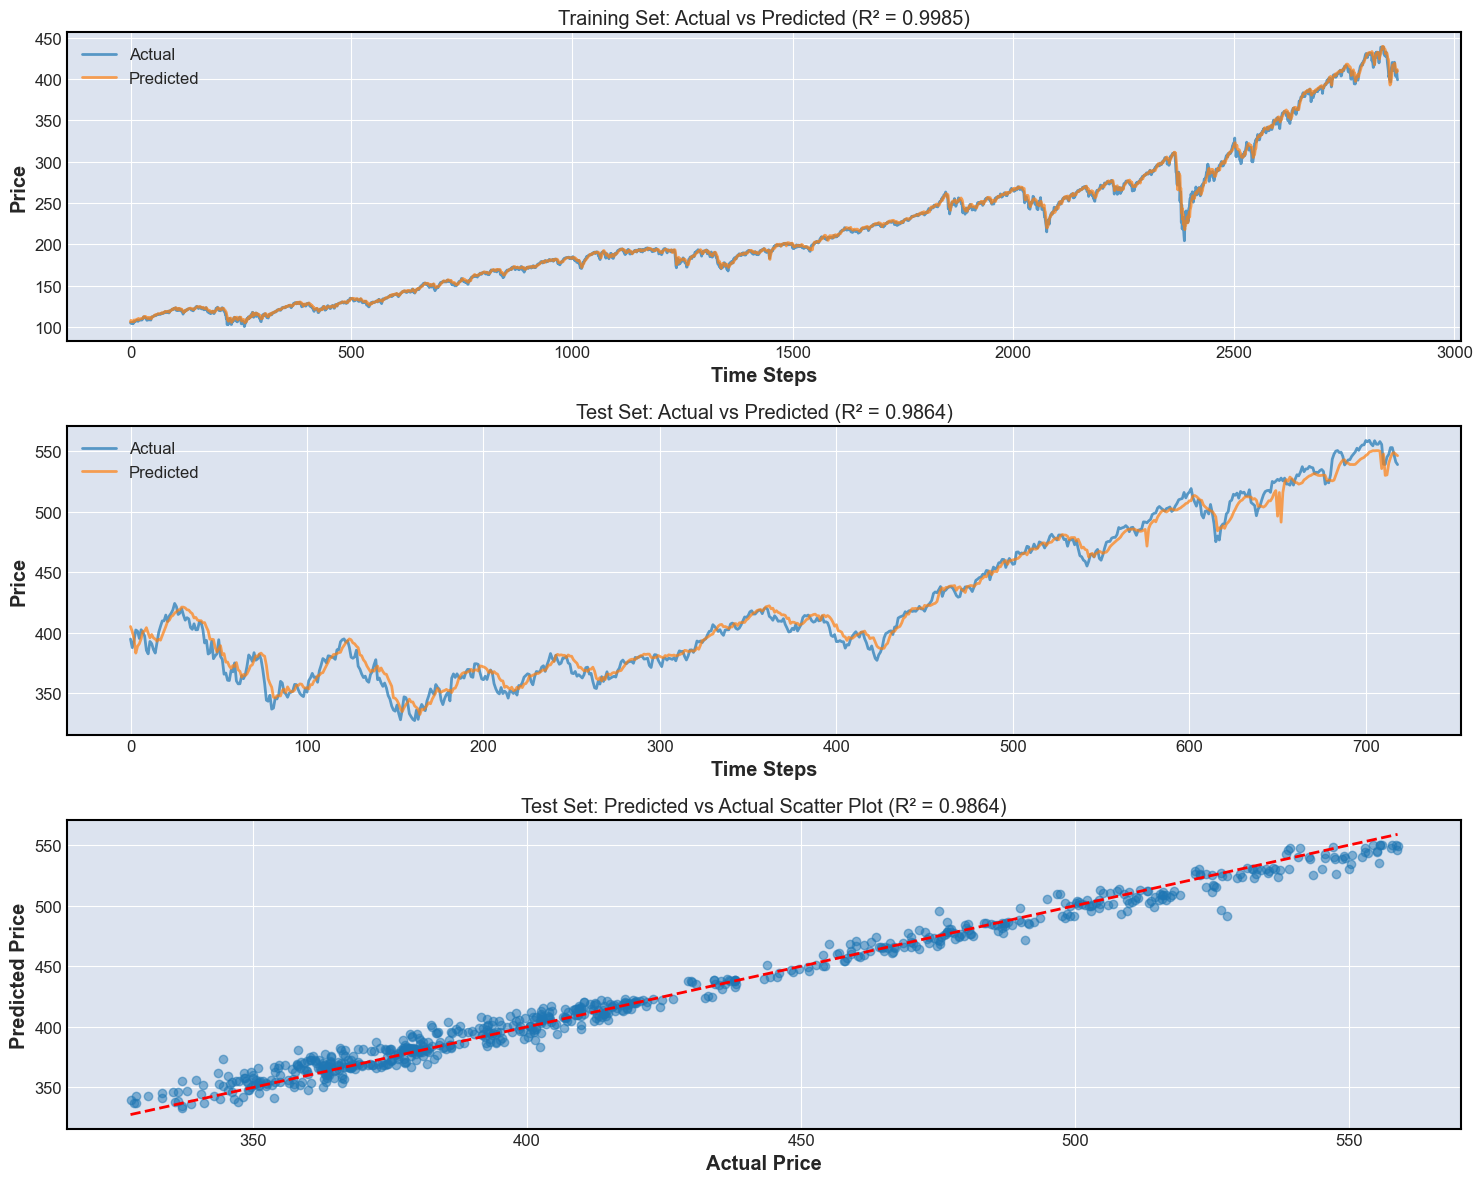

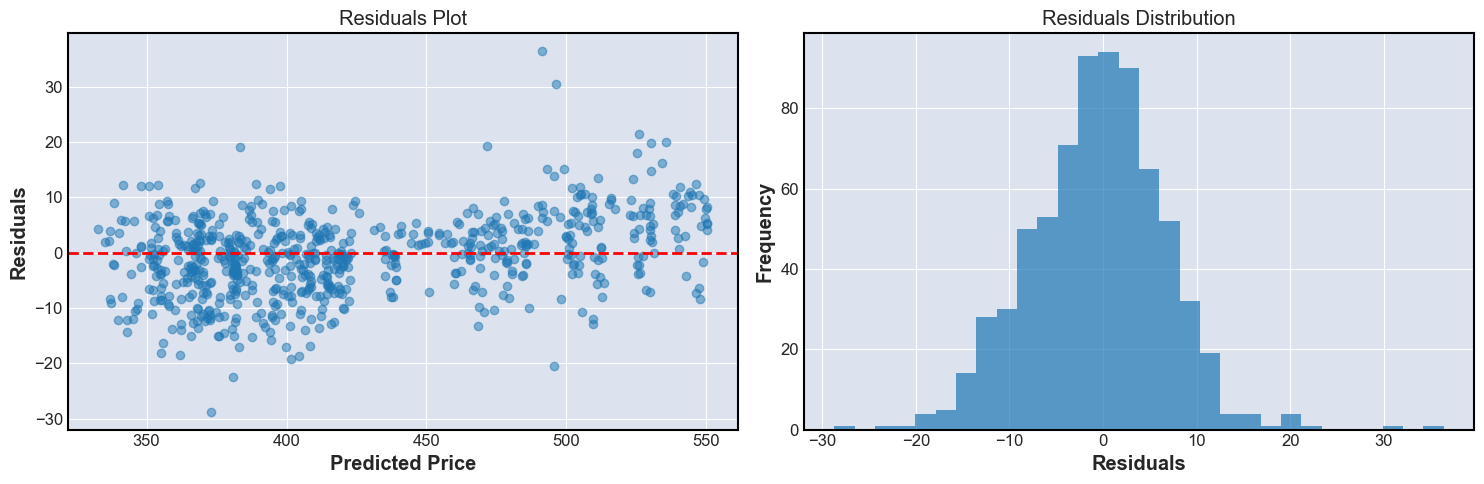


Model improvement over baseline:
MSE improvement: -174.75%
MAE improvement: -70.54%


In [ ]:
# Model evaluation and predictions
# Make predictions
print("Making predictions...")
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get actual price values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Flatten arrays
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()
y_train_actual = y_train_actual.flatten()
y_test_actual = y_test_actual.flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("\n=== CNN-LSTM Model Performance ===")
print(f"Training Set:")
print(f"  MSE: {train_mse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²:  {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²:  {test_r2:.4f}")

# Calculate baseline (naive prediction - previous day's price)
# For baseline, predict the last known price
baseline_pred = y_test_actual[:-1]  # Previous day's price
baseline_actual = y_test_actual[1:]  # Next day's actual price
baseline_mse = mean_squared_error(baseline_actual, baseline_pred)
baseline_mae = mean_absolute_error(baseline_actual, baseline_pred)
baseline_r2 = r2_score(baseline_actual, baseline_pred)

print(f"\n=== Baseline Performance (Previous Day Price) ===")
print(f"  MSE: {baseline_mse:.4f}")
print(f"  MAE: {baseline_mae:.4f}")
print(f"  R²:  {baseline_r2:.4f}")

# Plot predictions vs actual
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Training set predictions
ax1.plot(y_train_actual, label='Actual', alpha=0.7)
ax1.plot(y_train_pred, label='Predicted', alpha=0.7)
ax1.set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.4f})')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Price')
ax1.legend()

# Test set predictions
ax2.plot(y_test_actual, label='Actual', alpha=0.7)
ax2.plot(y_test_pred, label='Predicted', alpha=0.7)
ax2.set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Price')
ax2.legend()

# Scatter plot for test set
ax3.scatter(y_test_actual, y_test_pred, alpha=0.5)
ax3.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Price')
ax3.set_ylabel('Predicted Price')
ax3.set_title(f'Test Set: Predicted vs Actual Scatter Plot (R² = {test_r2:.4f})')

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test_actual - y_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Residuals plot
ax1.scatter(y_test_pred, residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Price')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals Plot')

# Residuals histogram
ax2.hist(residuals, bins=30, alpha=0.7)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Distribution')

plt.tight_layout()
plt.show()

print(f"\nModel improvement over baseline:")
print(f"MSE improvement: {(baseline_mse - test_mse)/baseline_mse*100:.2f}%")
print(f"MAE improvement: {(baseline_mae - test_mae)/baseline_mae*100:.2f}%")